# 12 Newton and Quasi-Newton Methods

In [40]:
import pandas as pd
import numpy as np 
from numpy import linalg as la
from matplotlib import pyplot as plt
import scipy.optimize as opt
import time

## Problem 1

In [41]:
def newton(df, d2f, x0, maxiter=1000, tol=1e-8):
    
    xk = x0
    err = tol + 1
    converged = True
    iteration = 0
    while (err > tol) and (iteration < maxiter):
        
        zk = la.solve(d2f(xk), df(xk))
        xk1 = xk - zk 
        err = la.norm(df(xk1), np.inf)
        xk = xk1
        iteration += 1
        
        if iteration == maxiter:
            converged = False
            
    return xk, converged, iteration        

In [42]:
f = opt.rosen
df = opt.rosen_der
d2f = opt.rosen_hess
newton(df, d2f, np.array([2,2]))

(array([1., 1.]), True, 5)

In [43]:
opt.fmin_bfgs(f=f, x0=[-2,2], fprime=df, maxiter=50)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


array([1.00000021, 1.00000045])

## Problem 2

In [44]:
def BFGS(df, x0, maxiter=1000, tol=1e-8):
    
    n = len(x0)
    Ak_inv = np.eye(n)
    
    xk = x0
    err = tol + 1
    converged = True
    iteration = 0
    while (err > tol) and (iteration < maxiter):
        
        xk1 = xk - Ak_inv @ df(xk).T
        
        sk = xk1 - xk
        yk = df(xk1).T - df(xk).T
        sk_dot_yk = sk.T @ yk
        
        if (sk_dot_yk)**2 == 0:
            return x0, False, maxiter
                
        term1 = Ak_inv
        term2 = ( (sk_dot_yk + yk.T @ Ak_inv @ yk) * np.outer(sk, sk) ) / (sk_dot_yk) ** 2
        term3 = (Ak_inv @ np.outer(yk, sk.T) + np.outer(sk, yk.T) @ Ak_inv) / sk_dot_yk
        Ak1_inv = term1 + term2 - term3
        
        err = la.norm(df(xk1), np.inf)
        xk = xk1
        Ak_inv = Ak1_inv
        
        if iteration == maxiter:
            converged = False
            
        iteration += 1
        
    return xk, converged, iteration   

In [45]:
f = opt.rosen
df = opt.rosen_der
d2f = opt.rosen_hess
BFGS(df, np.array([-2,2]), 400, 1e-6)

(array([1.0000001 , 1.00000019]), True, 145)

## Problem 3

In [48]:
def prob3(N):
    
    newton_time = np.zeros(N)
    BFGS_time = np.zeros(N)
    scipy_time = np.zeros(N)
    
    newton_iter = np.zeros(N)
    BFGS_iter = np.zeros(N)
    scipy_iter = np.zeros(N)
    
    f = opt.rosen
    df = opt.rosen_der
    d2f = opt.rosen_hess
    
    for i in range(N):
        x0 = np.random.uniform(-3, 3, 2)
        
        # Newton Method
        start_time = time.time()
        xk, converged, iteration = newton(df, d2f, x0)
        end_time = time.time() 
        newton_time[i] = end_time - start_time
        newton_iter[i] = iteration
        
        # BFGS Method
        start_time = time.time()
        xk, converged, iteration = BFGS(df, x0)
        end_time = time.time() 
        BFGS_time[i] = end_time - start_time
        BFGS_iter[i] = iteration
        
        # Scipy Method
        start_time = time.time()
        results = opt.fmin_bfgs(f, x0, fprime=df, disp=False, retall=1)
        end_time = time.time() 
        scipy_time[i] = end_time - start_time
        scipy_iter[i] = len(results[1])
        
    plt.loglog()
    plt.scatter(newton_time, newton_iter, alpha=0.5, label="Newton's Method")
    plt.scatter(BFGS_time, BFGS_iter, alpha=0.5, label='BFGS')
    plt.scatter(scipy_time, scipy_iter, alpha=0.5, label='scipy.optimize.fmin_bfgs()')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Iterations')
    plt.title('Computation Time Vs. Iterations')
    plt.legend()
    plt.show()

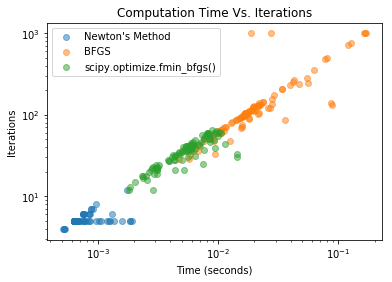

In [53]:
prob3(100)

## Problem 4

In [9]:
def gauss_newton(func, x0, Dfun, maxiter=500, tol=1e-5):
     
    xk = x0
    err = tol + 1
    converged = True
    iteration = 0
    while (err > tol) and (iteration < maxiter):
                
        df_xk = Dfun(xk).T @ func(xk)
        d2f_xk = Dfun(xk).T @ Dfun(xk)
        zk = la.solve(d2f_xk, df_xk)
        xk1 = xk - zk
        
        err = la.norm(xk1 - xk, np.inf)
        xk = xk1
        iteration += 1
        
        if iteration == maxiter:
            converged = False
            
    return xk, converged, iteration       

In [10]:
T = np.arange(10)
y = 3*np.sin(0.5*T)+ 0.5*np.random.randn(10)
model = lambda x, t: x[0]*np.sin(x[1]*t)
residual = lambda x: model(x, T) - y
jac = lambda x: np.column_stack((np.sin(x[1]*T), x[0]*T*np.cos(x[1]*T)))

In [17]:
gauss_newton(func=residual, x0=np.array([2.5,.6]), Dfun=jac)

(array([3.32744241, 0.51301394]), True, 4)

In [18]:
minx = opt.leastsq(func=residual, x0=np.array([2.5,.6]), Dfun=jac)
minx

(array([3.32744241, 0.51301394]), 1)

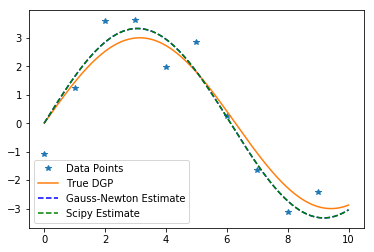

In [19]:
x, conv, niters = gauss_newton(func=residual, x0=np.array([2.5,.6]), Dfun=jac)
dom = np.linspace(0, 10, 200)
plt.plot(T, y, '*', label="Data Points")
plt.plot(dom, 3*np.sin(.5*dom), label="True DGP") 
plt.plot(dom, model(x, dom), '--', c='b', label="Gauss-Newton Estimate")
plt.plot(dom, model(minx[0], dom), '--', c='g', label="Scipy Estimate")
plt.legend()
plt.show()

## Problem 5

In [20]:
time, pop = np.load('population.npy').T

In [21]:
model2 = lambda x, t: x[0] * np.exp(x[1] * (t + x[2]))
residual2 = lambda x: model2(x, time) - pop
jac2 = lambda x: np.column_stack((np.exp(x[1]*(time + x[2])), \
                                  x[0]*(time + x[2])*np.exp(x[1]*(time + x[2])), \
                                  x[0]*x[1]*np.exp(x[1]*(time+x[2]))))

In [22]:
minx2 = opt.leastsq(func=residual2, x0=np.array([1.5, .4, 2.5]), Dfun=jac2)
minx2

(array([1.67729595, 0.18474177, 9.11885064]), 1)

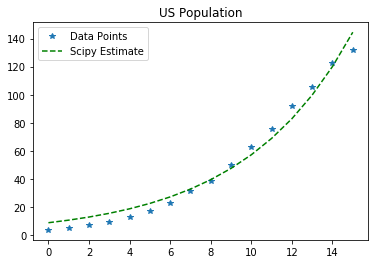

In [23]:
plt.plot(time, pop, '*', label="Data Points")
plt.plot(time, model2(minx2[0], time), '--', c='g', label="Scipy Estimate")
plt.title("US Population")
plt.legend()
plt.show()

In [36]:
model3 = lambda x, t: x[0]/(1 + np.exp(-x[1]*(t + x[2])))
residual3 = lambda x: model3(x, time) - pop
jac3 = lambda x: np.column_stack((1/(1 + np.exp(-x[1]*(time + x[2]))), \
                                 x[0]*(time + x[2])*np.exp(-x[1]*(time+x[2]))/(1 + np.exp(-x[1]*(time + x[2])))**(2), \
                                 x[0]*x[1]*np.exp(-x[1]*(time+x[2]))/(1 + np.exp(-x[1]*(time + x[2])))**(2)))

In [37]:
minx3 = opt.leastsq(func=residual3, x0=np.array([150, .4, -15]), Dfun=jac3)
minx3

(array([184.76582414,   0.32169312, -12.05552938]), 1)

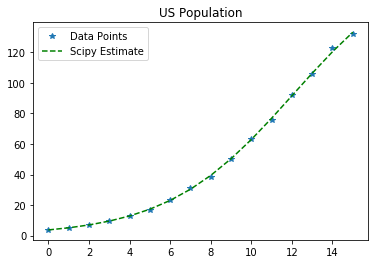

In [38]:
plt.plot(time, pop, '*', label="Data Points")
plt.plot(time, model3(minx3[0], time), '--', c='g', label="Scipy Estimate")
plt.title("US Population")
plt.legend()
plt.show()